In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from skimage.util import img_as_ubyte
from scipy.stats import skew, kurtosis
from skimage.feature import graycomatrix, graycoprops
import openpyxl

In [191]:
def collect_data(path_to_gen_folder):
    images = dict()
    labels = dict()
    for folder_name in os.listdir(path_to_gen_folder):
        if not(folder_name.isdigit()):
            continue
        class_path = os.path.join(path_to_gen_folder, folder_name)
        images[folder_name] = []
        labels[folder_name] = []

        if os.path.isdir(class_path):
            print(f"Загружаю данные из папки:{folder_name}")
            for filename in os.listdir(class_path):
                if filename.lower().endswith('.jpg'):
                    file_path = os.path.join(class_path, filename)
                    labels[folder_name].append(file_path)
                    image = cv2.imread(file_path)
                    if image is not None:
                        images[folder_name].append(image)
        print(f"Загрузка из папки:{folder_name} закончена")
    return images, labels



In [192]:
image_dict, labels = collect_data("Metrology-Meter-AI-CV-MIPT-AUT-2025")

Загружаю данные из папки:110
Загрузка из папки:110 закончена
Загружаю данные из папки:130
Загрузка из папки:130 закончена
Загружаю данные из папки:150
Загрузка из папки:150 закончена
Загружаю данные из папки:170
Загрузка из папки:170 закончена
Загружаю данные из папки:190
Загрузка из папки:190 закончена
Загружаю данные из папки:210
Загрузка из папки:210 закончена
Загружаю данные из папки:230
Загрузка из папки:230 закончена
Загружаю данные из папки:250
Загрузка из папки:250 закончена
Загружаю данные из папки:50
Загрузка из папки:50 закончена
Загружаю данные из папки:70
Загрузка из папки:70 закончена
Загружаю данные из папки:90
Загрузка из папки:90 закончена


In [193]:
gray_images_dict = dict()
for distance in image_dict:
    gray_images_dict[distance] = []
    j = image_dict[distance]
    for i in range(len(j)):
        gray_images_dict[distance].append(cv2.cvtColor(j[i], cv2.COLOR_BGR2GRAY))

gray_images_dict

{'110': [array([[155, 161, 161, ..., 173, 178, 179],
         [159, 166, 169, ..., 171, 179, 183],
         [161, 163, 167, ..., 175, 179, 184],
         ...,
         [106, 110, 112, ...,  48,  42,  40],
         [105, 110, 114, ...,  39,  47,  44],
         [108, 111, 113, ...,  35,  46,  47]],
        shape=(4096, 3072), dtype=uint8),
  array([[155, 155, 165, ..., 170, 165, 167],
         [155, 160, 166, ..., 175, 176, 186],
         [159, 163, 166, ..., 179, 179, 186],
         ...,
         [110, 110, 119, ...,  53,  53,  54],
         [107, 108, 118, ...,  50,  48,  48],
         [110, 108, 113, ...,  49,  44,  41]],
        shape=(4096, 3072), dtype=uint8),
  array([[167, 155, 156, ..., 178, 171, 163],
         [174, 167, 156, ..., 170, 185, 198],
         [166, 158, 147, ..., 177, 199, 202],
         ...,
         [104, 104, 104, ...,  69,  62,  69],
         [106, 111, 119, ...,  65,  53,  51],
         [125, 123, 122, ...,  63,  64,  39]],
        shape=(4096, 3072), dtype=ui

In [194]:
def calculate_basic_stats(gray_image):
    image_float = gray_image.astype(np.float32) / 255.0 # нормировка
    
    return {
        'brightness_mean': np.mean(image_float),
        'brightness_std': np.std(image_float),
        'brightness_skew': skew(image_float.flatten()),
        'brightness_kurtosis': kurtosis(image_float.flatten()),
        'brightness_median': np.median(image_float)
    }

In [195]:
def calculate_glcm_features(gray_image, distances=[1, 3, 5], 
                           angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    image_uint8 = img_as_ubyte(gray_image)
    
    glcm = graycomatrix(
        image_uint8, 
        distances=distances, 
        angles=angles,
        levels=256,
        symmetric=True, 
        normed=True
    )
    
    features = {}
    properties = ['contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity', 'ASM']
    
    for prop in properties:
        prop_values = graycoprops(glcm, prop)
        features[f'{prop}_mean'] = np.mean(prop_values)
        features[f'{prop}_std'] = np.std(prop_values)
    
    return features

In [196]:
def calculate_entropy(gray_image):
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist)) # по определению энтропии по Шеннону

In [208]:
def create_features_dataset_fixed(gray_images_dict, labels_dict):
    """Исправленная версия"""
    all_features = []
    
    for class_name, gray_images_list in gray_images_dict.items():
        print(f"Обрабатываю класс: {class_name}")
        
        for i, gray_image in enumerate(gray_images_list):
            # ВАЖНО: новый словарь для КАЖДОГО изображения
            features = {}
            
            # Базовая информация
            features['image_path'] = labels_dict[class_name][i]
            
            # Извлекаем характеристики
            features.update(calculate_basic_stats(gray_image))
            features.update(calculate_glcm_features(gray_image))
            features['entropy'] = calculate_entropy(gray_image)
            
            # Целевые переменные из имени класса
            features['target_distance'] = int(class_name)
            
            all_features.append(features)
    
    df = pd.DataFrame(all_features)
    print(f"Создан датасет: {len(df)} строк, {len(df.columns)} столбцов")
    return df

In [209]:
df = create_features_dataset_fixed(gray_images_dict, labels)

df.head()

Обрабатываю класс: 110
Обрабатываю класс: 130
Обрабатываю класс: 150
Обрабатываю класс: 170
Обрабатываю класс: 190
Обрабатываю класс: 210
Обрабатываю класс: 230
Обрабатываю класс: 250
Обрабатываю класс: 50
Обрабатываю класс: 70
Обрабатываю класс: 90
Создан датасет: 221 строк, 20 столбцов


,image_path,brightness_mean,brightness_std,brightness_skew,brightness_kurtosis,brightness_median,contrast_mean,contrast_std,energy_mean,energy_std,homogeneity_mean,homogeneity_std,correlation_mean,correlation_std,dissimilarity_mean,dissimilarity_std,ASM_mean,ASM_std,entropy,target_distance
0,Metrology-Meter-AI-CV-MIPT-AUT-2025\110\IMG_20...,0.639769,0.203450,-1.363443,0.974181,0.713726,57.768979,30.150929,0.033291,0.002860,0.333328,0.050254,0.989260,0.005610,3.578509,0.882144,0.001116,0.000201,6.977304,110
1,Metrology-Meter-AI-CV-MIPT-AUT-2025\110\IMG_20...,0.641862,0.199435,-1.405106,1.131407,0.717647,57.399746,30.006613,0.034271,0.002934,0.329619,0.050249,0.988895,0.005810,3.611069,0.883544,0.001183,0.000212,6.911588,110
2,Metrology-Meter-AI-CV-MIPT-AUT-2025\110\IMG_20...,0.640320,0.202021,-1.370528,1.037632,0.713726,93.291866,32.845284,0.022463,0.001233,0.193038,0.023042,0.982412,0.006200,6.034052,0.834147,0.000506,0.000057,7.043567,110
3,Metrology-Meter-AI-CV-MIPT-AUT-2025\110\IMG_20...,0.640331,0.202346,-1.386409,1.051723,0.717647,58.418051,30.553528,0.033137,0.002825,0.324083,0.049784,0.989021,0.005747,3.670452,0.891066,0.001106,0.000197,6.945364,110
4,Metrology-Meter-AI-CV-MIPT-AUT-2025\110\IMG_20...,0.590086,0.202045,-0.124181,-0.784241,0.564706,124.060947,62.024363,0.028563,0.002694,0.334168,0.051641,0.976635,0.011680,5.577447,1.604361,0.000823,0.000161,7.424568,110


In [ ]:
# Сохранение в CSV
df.to_csv('texture_features_dataset.csv', index=False)
print("Датасет сохранен как 'texture_features_dataset.csv'")

# Дополнительно в Excel
df.to_excel('texture_features_dataset.xlsx', index=False)

Датасет сохранен как 'texture_features_dataset.csv'


In [200]:
def plot_sample_images(df, num_samples=5):
    unique_folders = df['target'].unique()
    
    fig, axes = plt.subplots(2, min(num_samples, len(unique_folders)), figsize=(30, 10))
    if len(unique_folders) == 1:
        axes = np.array([axes]).T
    
    for i, folder in enumerate(unique_folders[:num_samples]):
        sample = df[df['target'] == folder].iloc[0]
        
        try:
            img = cv2.imread(sample['image_path'])
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[0, i].imshow(img_rgb)
            axes[0, i].set_title(f"Папка: {folder}", fontsize=10)
            axes[0, i].axis('off')
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            axes[1, i].hist(gray.ravel(), bins=50, alpha=0.7, color='gray')
            axes[1, i].set_title("Гистограмма", fontsize=10)
            axes[1, i].set_xlabel("Яркость")
            axes[1, i].set_ylabel("Частота")
            
        except Exception as e:
            print(f"Ошибка загрузки {sample['image_path']}: {e}")
            axes[0, i].text(0.5, 0.5, 'Ошибка\nзагрузки', 
                          ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_texture_features(df):
    """Распределение основных текстурных признаков"""
    texture_features = ['contrast_mean', 'energy_mean', 'entropy', 'homogeneity_mean', 
                       'brightness_mean', 'brightness_std']

    existing_features = [f for f in texture_features if f in df.columns]
    
    n_features = len(existing_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.ravel()
    
    for i, feature in enumerate(existing_features):
        axes[i].hist(df[feature], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[i].set_title(f'Распределение {feature}', fontsize=12)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Частота')
        axes[i].grid(True, alpha=0.3)
        
        mean_val = df[feature].mean()
        std_val = df[feature].std()
        axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_val:.2f}')
        axes[i].axvline(mean_val + std_val, color='orange', linestyle=':', linewidth=1, alpha=0.7)
        axes[i].axvline(mean_val - std_val, color='orange', linestyle=':', linewidth=1, alpha=0.7)
        axes[i].legend()
    
    for i in range(len(existing_features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()


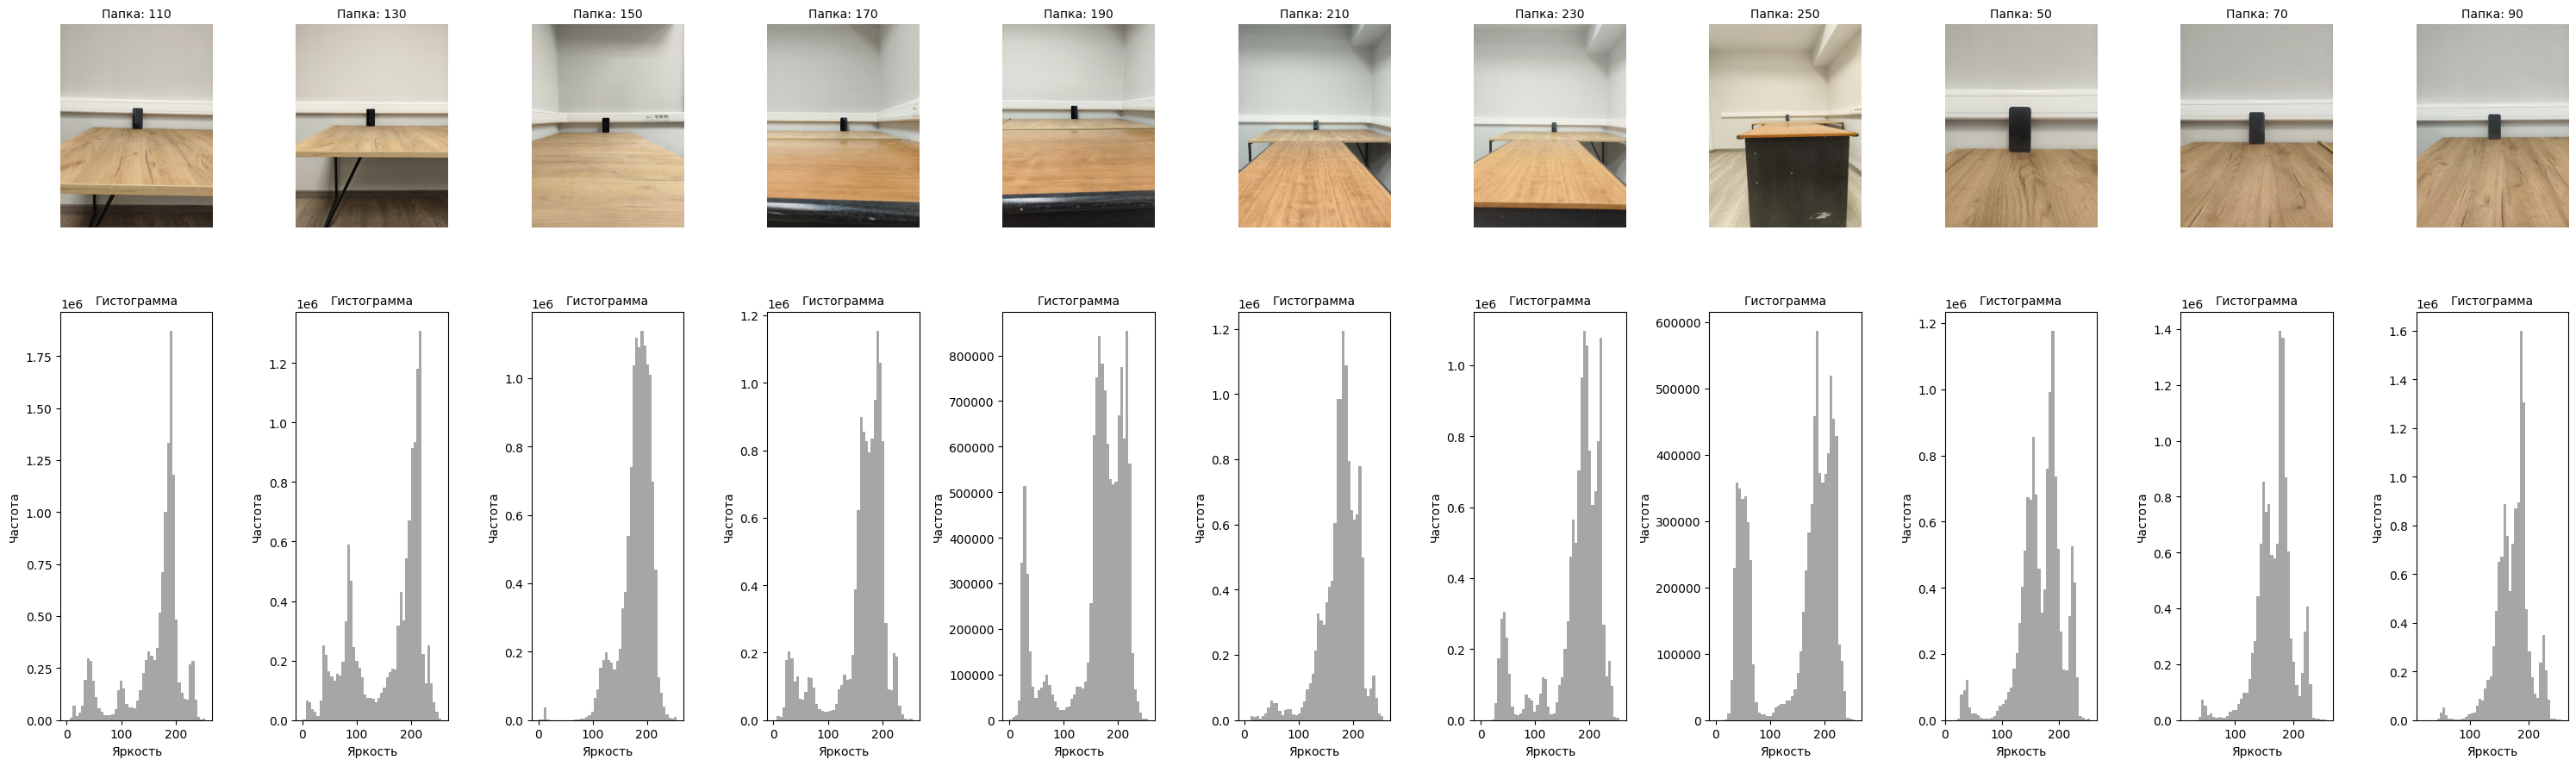

In [201]:
plot_sample_images(df, 11)

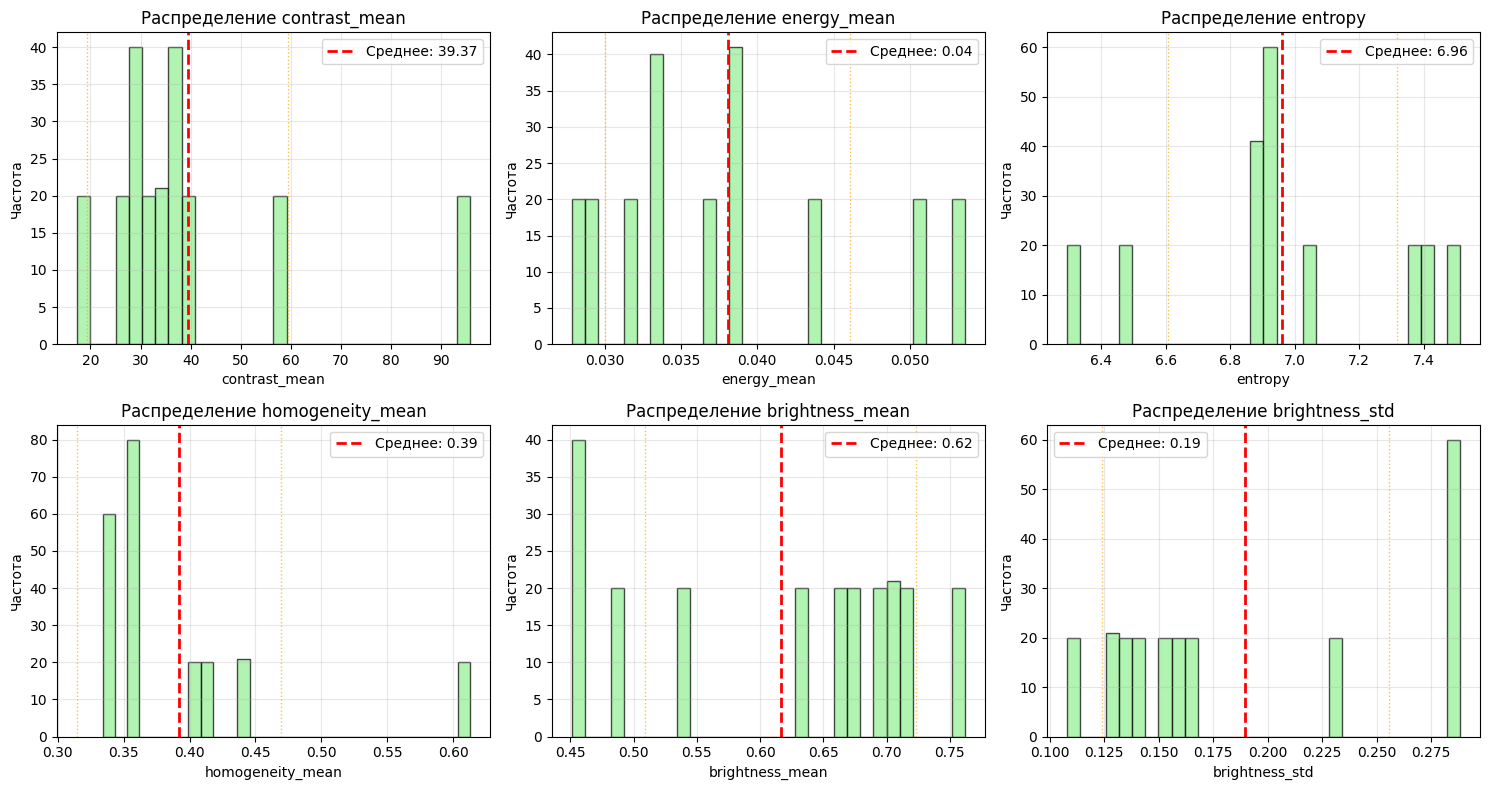

In [202]:
plot_texture_features(df)